# Import Dependencies

In [31]:
import math
import numpy as np
from numpy import sort
import pandas as pd
import pickle
import time
import random
from scipy import stats 

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set(style='white', palette = 'Paired')
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
from ipywidgets import interactive, FloatSlider

from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, recall_score,\
precision_recall_fscore_support
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import imblearn

from collections import Counter
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb
from xgboost import XGBRegressor

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_regression, RFE, RFECV

from sklearn.preprocessing import OneHotEncoder

# Import Data

In [75]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# EDA

In [76]:
# Drop Id column

df.drop(columns='Id', inplace=True)
df_test.drop(columns='Id', inplace=True)

In [77]:
# Split YearBuilt to 'new' = 1, 'old' = 0

df['YearBuilt'] = np.array([1 if x >= 1999 else 0 for x in df['YearBuilt']])
df_test['YearBuilt'] = np.array([1 if x >= 1999 else 0 for x in df_test['YearBuilt']])

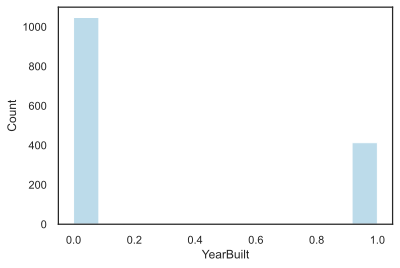

In [78]:
sns.histplot(df['YearBuilt']);

In [79]:
# Alley, PoolQC and MiscFeature have very little values in their column, so let;s go ahead and remove those columns

df.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)
df_test.drop(columns=['Alley', 'PoolQC', 'MiscFeature'], inplace=True)

In [80]:
# Let's fill in the NaNs with the mean for numerical columns

df.fillna(value=df.mean(), inplace=True)
df_test.fillna(value=df_test.mean(), inplace=True)

In [81]:
# Establish catericals and numericals and put column names in 2 lists

categoricals = list(df.select_dtypes(include='object').columns)
categoricals_test = list(df_test.select_dtypes(include='object').columns)

numericals = list(df.select_dtypes(include='number').columns)
numericals_test = list(df_test.select_dtypes(include='number').columns)

In [82]:
def fill_categoricals(df, categoricals, numericals):
    """
    Take in a dataframe, categorical columns list, numerical columns list, and returns a dataframe with the categorical columns encoded.
    """
    
    # Let's replace categorical values with random values from the columns
    count = df.isna().sum().sum()
    
    while count > 0:
        
        for column in list(df[categoricals].columns):
            # Creates a random permutation of the categorical calues
            permutation = np.random.permutation(df[column])

            # Erase the empty values
            is_empty = np.where(permutation == "")
            permutation = np.delete(permutation, is_empty)

            # Replace all empty values of the dataframe
            end = len(permutation)
            df[column] = df[column].apply(lambda x: permutation[np.random.randint(end)] if pd.isnull(x) else x)
            
        count = df.isna().sum().sum()

In [83]:
fill_categoricals(df, categoricals, numericals)
fill_categoricals(df_test, categoricals_test, numericals_test)

In [84]:
print(df.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [85]:
# Encode categorical columns

def encode_cats(df, categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(df.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=df.index) #keep the same index values
    
    return pd.concat([df.loc[:, numericals], X_ohe], axis=1)

In [86]:
df = encode_cats(df, categoricals, numericals)
df_test = encode_cats(df_test, categoricals_test, numericals_test)

In [87]:
df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,1,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,0,1976,0.0,978,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,1,2002,162.0,486,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,0,1970,0.0,216,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,1,2000,350.0,655,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1,2000,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,20,85.0,13175,6,6,0,1988,119.0,790,163,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,70,66.0,9042,7,9,0,2006,0.0,275,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1458,20,68.0,9717,5,6,0,1996,0.0,49,1029,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [88]:
df_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,0,1961,0.0,468.0,144.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20,81.0,14267,6,6,0,1958,108.0,923.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60,74.0,13830,5,5,0,1998,0.0,791.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60,78.0,9978,6,6,0,1998,20.0,602.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,120,43.0,5005,8,5,0,1992,0.0,263.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,0,1970,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1455,160,21.0,1894,4,5,0,1970,0.0,252.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,20,160.0,20000,5,7,0,1996,0.0,1224.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,85,62.0,10441,5,5,0,1992,0.0,337.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Base Model

In [124]:
def test_train_split(X, y):
    """
    Takes the feature and target data and returns the test_train splits.
    Then, X and y and converted to np.array so it can be used in kf function below
    """

    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

    # this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)

    return X, X_test, y, y_test

In [125]:
def scale_X_test(X_test):
    """
    Takes in a dataframe of X_test features and scales them
    """

    # Scale features and test data

    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)

    return X_test_scaled

In [126]:
def regression_analysis(X, X_test, y, y_test):
        """
        Conducts regression anlaysls. Prints R-squared and MAE for each algorithm
        """
        kf = KFold(n_splits=5, shuffle=True, random_state = 42)
        lr_scores, lr_ridge_scores, lr_lasso_scores, \
        lr_elastic_scores, lr_xgb_scores = [], [], [], [], [] #collect the validation results for all models

        for train_ind, val_ind in kf.split(X,y):

            X_train, y_train = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind] 

            # scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # load models
            lr = LinearRegression()
            lr_ridge = RidgeCV(cv=5)
            lr_lasso = LassoCV(cv=5, tol=0.5, max_iter=50000)
            lr_elastic = ElasticNetCV(cv=5, random_state=42, tol=0.5, max_iter=50000)
            lr_xgb = XGBRegressor(n_estimators=150, learning_rate=0.15)

            # fit models
            lr.fit(X_train_scaled, y_train)
            lr_ridge.fit(X_train_scaled, y_train)
            lr_lasso.fit(X_train_scaled, y_train)
            lr_elastic.fit(X_train_scaled, y_train)
            lr_xgb.fit(X_train_scaled, y_train)

            # create lists of scores
            lr_scores.append(lr.score(X_val_scaled, y_val))
            lr_ridge_scores.append(lr_ridge.score(X_val_scaled, y_val))
            lr_lasso_scores.append(lr_lasso.score(X_val_scaled, y_val))
            lr_elastic_scores.append(lr_elastic.score(X_val_scaled, y_val))
            lr_xgb_scores.append(lr_xgb.score(X_val_scaled, y_val))

        # Test
        
        # Prints all of our metrics
        
        print(f'Linear Regression val R^2: {np.mean(lr_scores):.3f} +- {np.std(lr_scores):.3f}')
        print(f'Linear Regression test R^2: {lr.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test_scaled), squared=False):.3f}\n')
        
        print(f'Ridge Regression val R^2: {np.mean(lr_ridge_scores):.3f} +- {np.std(lr_ridge_scores):.3f}')
        print(f'Ridge Regression test R^2: {lr_ridge.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_ridge.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'Lasso Regression val R^2: {np.mean(lr_lasso_scores):.3f} +- {np.std(lr_lasso_scores):.3f}')
        print(f'Lasso Regression test R^2: {lr_lasso.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_lasso.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'Elastic Net Regression val R^2: {np.mean(lr_elastic_scores):.3f} +- {np.std(lr_elastic_scores):.3f}')
        print(f'Elastic Net Regression test R^2: {lr_elastic.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_elastic.predict(X_test_scaled), squared=False):.3f}\n')

        print(f'XGBoost Regression val R^2: {np.mean(lr_xgb_scores):.3f} +- {np.std(lr_xgb_scores):.3f}')
        print(f'XGBoost Regression test R^2: {lr_xgb.score(X_test_scaled, y_test):.3f}')
        print(f'RMSE: {mean_squared_error(y_test, lr_xgb.predict(X_test_scaled), squared=False):.3f}')
        
        # Put models and respective scores in a list
        
        model_score_list = [[lr, lr.score(X_test_scaled, y_test)],
                   [lr_ridge, lr_ridge.score(X_test_scaled, y_test)],
                   [lr_lasso, lr_lasso.score(X_test_scaled, y_test)],
                   [lr_elastic, lr_elastic.score(X_test_scaled, y_test)],
                   [lr_xgb, lr_xgb.score(X_test_scaled, y_test)]]
        
        model_score_list = sorted(model_score_list, key = lambda x: x[1])
        
        # Return model with highest R-squared
        
        return model_score_list[-1][0]

In [127]:
def plot_residuals(model):
    """
    Residuals v Predicted plot
    """

    residuals = y_test - model.predict(X_test_scaled)

    plt.figure(figsize=(10, 7))
    plt.scatter(model.predict(X_test_scaled), residuals)   

    plt.axhline(0, linestyle='--', color='gray')
    plt.xlabel('Predicted Values', fontsize=18)
    plt.ylabel('Residuals', fontsize=18);

In [145]:
# Establish features and target

X = df.drop(columns='SalePrice')

y = df['SalePrice']

In [146]:
X.shape

(1460, 239)

In [129]:
X, X_test, y, y_test = test_train_split(X, y)

In [130]:
X_test_scaled = scale_X_test(X_test)

In [131]:
model  = regression_analysis(X, X_test, y, y_test)

Linear Regression val R^2: -15095465763944745926656.000 +- 18448696325985993228288.000
Linear Regression test R^2: -135139659148204097536.000
RMSE: 1018118494672798.500

Ridge Regression val R^2: 0.792 +- 0.077
Ridge Regression test R^2: 0.822
RMSE: 36947.269

Lasso Regression val R^2: 0.711 +- 0.113
Lasso Regression test R^2: 0.821
RMSE: 37056.691

Elastic Net Regression val R^2: 0.244 +- 0.009
Elastic Net Regression test R^2: 0.233
RMSE: 76723.461

XGBoost Regression val R^2: 0.837 +- 0.042
XGBoost Regression test R^2: 0.900
RMSE: 27634.977


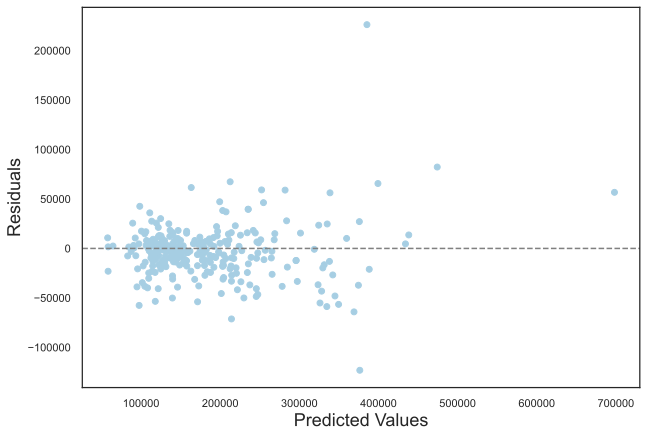

In [132]:
plot_residuals(model)

# Make Predictions

In [135]:
# Establish features

X = df_test

In [147]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,1,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,0,1976,0.0,978,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,1,2002,162.0,486,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,0,1970,0.0,216,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,1,2000,350.0,655,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1,2000,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,20,85.0,13175,6,6,0,1988,119.0,790,163,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,70,66.0,9042,7,9,0,2006,0.0,275,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1458,20,68.0,9717,5,6,0,1996,0.0,49,1029,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [136]:
X_test_scaled = scale_X_test(X)

In [141]:
model.predict(X)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238'] ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_GasW', 'Heating_Grav', 'Heating_Wall', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_Y', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']
expected f14, f160, f225, f230, f190, f191, f206, f229, f116, f111, f234, f2, f36, f131, f210, f99, f237, f18, f78, f148, f222, f114, f121, f161, f158, f94, f41, f93, f46, f70, f119, f112, f200, f123, f113, f176, f33, f64, f81, f17, f44, f110, f128, f178, f120, f181, f108, f183, f38, f43, f60, f193, f145, f7, f22, f50, f138, f232, f76, f196, f100, f173, f79, f72, f15, f186, f19, f27, f155, f168, f231, f130, f220, f127, f48, f58, f169, f8, f141, f139, f177, f217, f199, f218, f97, f47, f159, f62, f135, f45, f66, f219, f132, f197, f74, f152, f212, f226, f57, f88, f146, f115, f92, f207, f142, f224, f144, f175, f126, f83, f214, f174, f0, f167, f85, f228, f179, f223, f37, f198, f69, f140, f147, f216, f29, f23, f26, f1, f31, f205, f30, f34, f109, f6, f211, f172, f195, f95, f153, f20, f65, f194, f180, f202, f221, f63, f150, f122, f184, f98, f71, f143, f10, f25, f59, f164, f39, f3, f103, f171, f21, f13, f82, f16, f215, f53, f54, f185, f35, f124, f28, f11, f133, f42, f107, f165, f118, f101, f125, f163, f68, f129, f166, f24, f170, f12, f56, f136, f189, f75, f84, f86, f87, f182, f77, f209, f40, f151, f227, f91, f106, f9, f96, f236, f32, f203, f156, f192, f5, f201, f80, f90, f61, f204, f4, f137, f154, f73, f188, f67, f117, f105, f49, f149, f235, f51, f104, f187, f52, f208, f55, f102, f213, f89, f157, f238, f233, f162, f134 in input data
training data did not have the following fields: CentralAir_Y, BsmtFullBath, GarageCond_TA, GarageType_BuiltIn, RoofStyle_Mansard, GarageFinish_RFn, LandContour_Low, Condition1_RRAe, Neighborhood_ClearCr, Neighborhood_NridgHt, KitchenQual_Fa, GarageType_Attchd, Neighborhood_NWAmes, Exterior1st_CemntBd, MoSold, LotShape_IR3, BldgType_Duplex, BsmtCond_TA, FireplaceQu_Fa, Functional_Min2, Fireplaces, RoofStyle_Gambrel, Exterior2nd_AsphShn, Heating_Grav, GrLivArea, GarageYrBlt, KitchenQual_Gd, Exterior2nd_HdBoard, Neighborhood_NPkVill, Exterior2nd_CBlock, BsmtFinType2_BLQ, LandContour_HLS, Exterior1st_Stucco, SaleType_ConLD, ExterQual_TA, BsmtCond_Gd, LotConfig_FR3, KitchenQual_TA, Condition2_PosA, ExterCond_Po, RoofMatl_WdShake, FireplaceQu_Po, GarageCond_Gd, LotShape_IR2, Exterior2nd_Stucco, OverallCond, LandSlope_Sev, Exterior1st_BrkComm, Neighborhood_BrDale, Neighborhood_Crawfor, GarageArea, Street_Pave, KitchenAbvGr, LotConfig_Inside, Fence_MnPrv, Neighborhood_Sawyer, FireplaceQu_TA, SaleCondition_AdjLand, HouseStyle_2.5Unf, Fence_GdWo, 3SsnPorch, BsmtFinType1_Rec, GarageType_Detchd, Exterior2nd_ImStucc, HouseStyle_SLvl, RoofStyle_Shed, Neighborhood_Edwards, RoofStyle_Gable, BsmtExposure_No, ExterCond_Fa, BsmtFinType2_Unf, Condition1_RRNn, HouseStyle_SFoyer, BsmtFinType2_GLQ, TotalBsmtSF, Exterior2nd_Plywood, MasVnrType_None, Neighborhood_NAmes, ExterCond_TA, BsmtFinType1_LwQ, HouseStyle_2Story, SaleType_New, Neighborhood_MeadowV, BldgType_2fmCon, SaleCondition_Partial, ScreenPorch, Condition1_PosA, SaleCondition_Family, BsmtExposure_Mn, BsmtUnfSF, BsmtCond_Po, LowQualFinSF, Condition1_Norm, Exterior1st_HdBoard, Exterior2nd_BrkFace, BsmtFinType1_BLQ, GarageQual_Gd, ExterQual_Fa, Neighborhood_Timber, Neighborhood_OldTown, LandSlope_Mod, Neighborhood_BrkSide, Exterior2nd_MetalSd, Foundation_PConc, MiscVal, SaleCondition_Normal, EnclosedPorch, HeatingQC_Po, MasVnrArea, Exterior1st_Wd Sdng, BsmtFinSF2, RoofMatl_Tar&Grv, Condition2_Feedr, Heating_Wall, Condition1_PosN, BsmtQual_TA, Exterior1st_AsphShn, LotShape_Reg, 2ndFlrSF, Heating_GasW, Neighborhood_NoRidge, Exterior1st_BrkFace, Exterior2nd_Brk Cmn, Condition1_Feedr, GarageQual_TA, Electrical_FuseF, Neighborhood_Blueste, FireplaceQu_Gd, BsmtFinSF1, GarageCond_Po, OverallQual, LotArea, TotRmsAbvGrd, Exterior2nd_CmentBd, GarageCars, Neighborhood_Veenker, OpenPorchSF, MasVnrType_Stone, Exterior2nd_VinylSd, Fence_MnWw, BsmtExposure_Gd, RoofStyle_Hip, MSZoning_RH, Functional_Maj2, Exterior2nd_Wd Sdng, LotConfig_FR2, BsmtQual_Gd, GarageCond_Fa, WoodDeckSF, LotFrontage, PoolArea, SaleType_ConLw, Exterior1st_MetalSd, BldgType_TwnhsE, GarageType_CarPort, BsmtFinType2_Rec, Condition1_RRNe, Foundation_Stone, BsmtFinType2_LwQ, BldgType_Twnhs, BsmtQual_Fa, HeatingQC_TA, Condition2_Norm, MSZoning_RM, Exterior1st_Plywood, ExterCond_Gd, Electrical_SBrkr, MSSubClass, Functional_Min1, YearBuilt, SaleType_WD, Neighborhood_Somerst, HalfBath, Exterior1st_CBlock, Neighborhood_StoneBr, ExterQual_Gd, GarageFinish_Unf, LotConfig_CulDSac, Exterior2nd_Stone, SaleType_Con, BsmtFinType1_Unf, Exterior1st_VinylSd, SaleCondition_Alloca, Foundation_CBlock, MSZoning_RL, BsmtHalfBath, RoofMatl_WdShngl, MasVnrType_BrkFace, SaleType_ConLI, PavedDrive_Y, Foundation_Slab, Neighborhood_IDOTRR, Neighborhood_CollgCr, MSZoning_FV, YearRemodAdd, HouseStyle_1Story, BsmtFinType1_GLQ, SaleType_CWD, HouseStyle_1.5Unf, Neighborhood_SawyerW, Foundation_Wood, Exterior1st_WdShing, Electrical_FuseP, YrSold, Condition2_PosN, Functional_Typ, PavedDrive_P, Neighborhood_Gilbert, BedroomAbvGr, FullBath, HeatingQC_Fa, Condition1_RRAn, SaleType_Oth, Exterior2nd_Wd Shng, HeatingQC_Gd, GarageQual_Po, Neighborhood_SWISU, Neighborhood_Mitchel, LandContour_Lvl, GarageType_Basment, Functional_Sev, 1stFlrSF, Functional_Mod